-- нужно
добавить фильтры на карту - по развитию компании, по направлению (оквед), по группе деятельности ( бар / досуг ... )
сравнение статистики с конкурентами
экономическая карта города - где с чем плохо и чего не хватает (не хватает баров с хорошим ремонтом)...

-- экстра
? добавить иностранные источники - если предприниматель ориентируется на гостей столицы (сказать что можем добавить)
возможность самому задавать негативные слова (показать, какие слова выделили?)
есть статистика по точскам, следующий шаг - объединять точки в предприятия (круто для мест где для точки мало комментариев) 
выявление именнованых сущностей - сравнение с конкурентами

-- говорим
добавим другие (яндекс) данные об отзывах (не в мвп)

In [1]:
import pandas as pd
import numpy as np
import ast
import tqdm

from datetime import datetime
import pickle
import time
import requests
from bs4 import BeautifulSoup
from lxml import html
import json
import operator
import math

%matplotlib inline 
from nltk.collocations import *
import pandas as pd
from collections import Counter
import functools
import tqdm
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from itertools import product
from __future__ import division
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import nltk, string
from nltk.tokenize import punkt
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import pymorphy2
import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import  roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
# exclude = set(punctuation + u'0123456789[]—«»–')
exclude = set(punctuation + u'[]—«»–')
import requests
import json

pd.set_option('max_columns', 100)
# import vk

%matplotlib inline

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def preprocess(text):
    
    buf = ''.join(ch for ch in text if ch not in exclude)
    tokens = WhitespaceTokenizer().tokenize(buf.lower())
    lemmatizer = MorphAnalyzer()
    lemmas = []
    for t in tokens[:]:
        if not t in stopwords.words('russian'):
            try:
                int(t)
                continue
            except:
                try:
                    lemma = lemmatizer.parse(t)[0].normal_form
                except: 
                    lemma = t
                lemmas.append(lemma)
    return ' '.join(lemmas)

In [3]:
# df = pd.read_csv('document.csv', encoding='cp1251')
df = pd.read_csv('rev1.csv', encoding='cp1251')
df1 = pd.read_csv('rev2.csv', encoding='cp1251')
df2 = pd.read_csv('rev3.csv', encoding='cp1251')
df = df.append(df1).append(df2)
df.reset_index(inplace = True, drop = True)

In [4]:
df.head(3)

company_id                        website  \
0  ChIJq_qjF8g0tUYRfuItAbh2U1g  http://www.victoria-group.ru/   
1  ChIJq_qjF8g0tUYRfuItAbh2U1g  http://www.victoria-group.ru/   
2  ChIJq_qjF8g0tUYRfuItAbh2U1g  http://www.victoria-group.ru/   

                                        company_type company_name  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...     Виктория   
1  ['supermarket', 'grocery_or_supermarket', 'foo...     Виктория   
2  ['supermarket', 'grocery_or_supermarket', 'foo...     Виктория   

                                         review_text  review_rating  \
0  Замечательный магазин. Стоит по качеству и асс...            5.0   
1  Огррмный ассортимент. Но цены слишком боллшие ...            1.0   
2  В целом неплохой магазин, но не раз встречала ...            4.0   

    review_time  
0  1.558824e+09  
1  1.547626e+09  
2  1.552293e+09

In [5]:
# tqdm.pandas()

In [6]:
def prep(x):
    url = x
    try:
        r = requests.get(url)
        sm_sites = ['twitter.com','facebook.com','vk.com','instagram.com']
        sm_sites_present = []

        soup = BeautifulSoup(r.content, 'html5lib')
        all_links = soup.find_all('a', href = True)


        for sm_site in sm_sites:
            for link in all_links:
                if sm_site in link.attrs['href']:
                    sm_sites_present.append(link.attrs['href'])
    except:
        return None


    return sm_sites_present

In [10]:
df = df[['website']].drop_duplicates()

In [ ]:
%%time
df['social_networks'] = df.apply(lambda x: prep(x.website), axis = 1)

In [ ]:
df.to_csv('rev_with_soc.csv', encoding = 'cp1251', index = False)

**save & load**

In [90]:
# df.to_csv('rev1_1_prep.csv', index = False)
# df = 

**comp stats**

In [80]:
df.company_type_single.nunique()

73

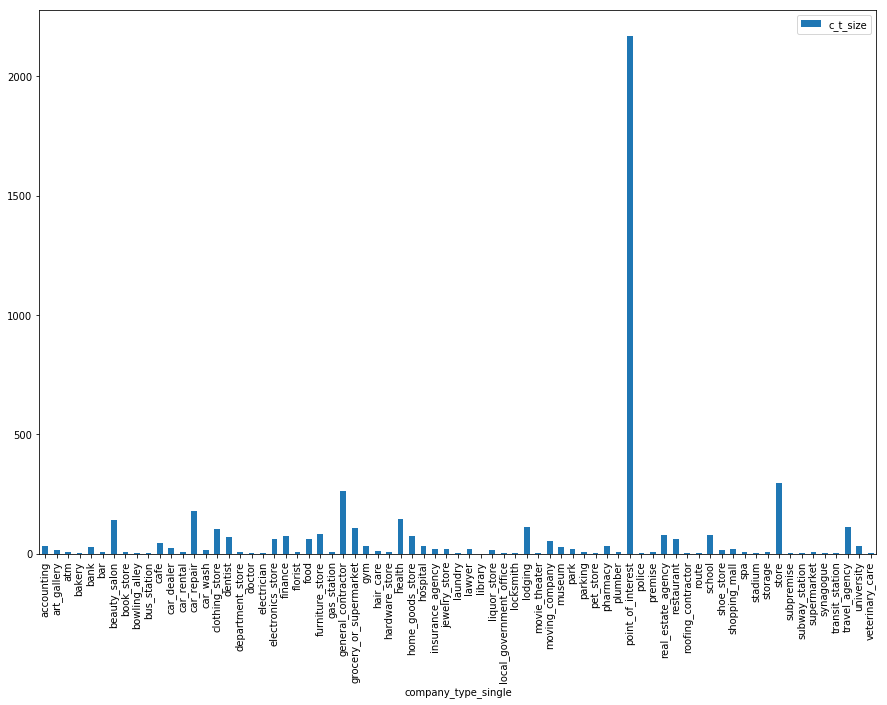

In [86]:
df.groupby(['company_type_single']).size().reset_index().rename(columns = {0:'c_t_size'}).plot(x = 'company_type_single', y = 'c_t_size', kind = 'bar', rot = 90, figsize = (15, 10))

In [95]:
comb_dict = {'drop':['point_of_interest', 'route', 'parking', 'local_government_office', 'atm', 'park', 'travel_agency', 'lodging',
                    'real_estate_agency','pet_store', 'general_contractor', 'subway_station', 'stadium', 'book_store',
                    'police', 'synagogue', 'transit_station', 'moving_company', 'gas_station', 'bowling_alley', 'subpremise'], 
             'finance':['accounting', 'bank', 'finance', 'accounting', 'library', 'bus_station', 'premise', 'roofing_contractor'], 
             'retail':['supermarket', 'store', 'clothing_store', 'shoe_store', 'electronics_store', 'home_goods_store',
                      'furniture_store', 'jewelry_store', 'grocery_or_supermarket', 'hardware_store', 'liquor_store', 
                      'shopping_mall', 'department_store'],
             'food':['restaurant', 'food', 'bakery', 'bar', 'cafe'],
             'edu':['school', 'university'],
            'health':['health', 'gym', 'dentist', 'hospital', 'pharmacy', 'veterinary_care', 'doctor'],
            'beauty':['hair_care', 'florist', 'art_gallery', 'spa', 'museum', 'beauty_salon', 'movie_theater'],
            'service':['car_wash', 'car_repair', 'insurance_agency', 'laundry', 'plumber', 'car_rental', 'car_dealer', 'electrician', 'storage',
                      'locksmith']}

In [101]:
for item in comb_dict:
    key  = item[0]
    vals = item[1]

In [105]:
def get_comb(x):
    
    for item in comb_dict.items():
        key  = item[0]
        vals = item[1]
        
        if x in vals:
            return key
        
    return None

In [107]:
df['company_type_single_big'] = df.company_type_single.apply(lambda x: get_comb(x))

In [109]:
df['company_type_single_big'].unique()

array(['retail', 'drop', 'finance', 'edu', None, 'health', 'beauty',
       'service', 'food'], dtype=object)

In [110]:
df = df[(pd.notnull(df.company_type_single_big))&(df.company_type_single_big != 'drop')].copy()

In [111]:
df.head(1)

company_id                        website  \
0  ChIJq_qjF8g0tUYRfuItAbh2U1g  http://www.victoria-group.ru/   

                                        company_type company_name  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...     Виктория   

                                         review_text  review_rating  \
0  Замечательный магазин. Стоит по качеству и асс...            5.0   

          review_time                                  review_lemmatized  \
0 2019-05-25 22:44:07  замечательный магазин стоить качество ассортим...   

  company_type_single company_type_single_big  
0         supermarket                  retail

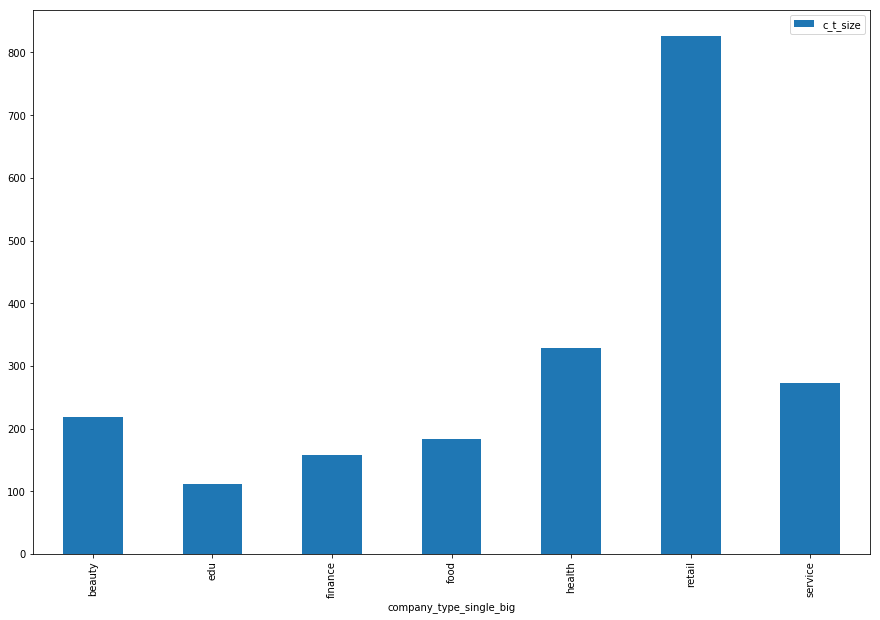

In [112]:
df.groupby(['company_type_single_big']).size().reset_index().rename(columns = {0:'c_t_size'}).plot(x = 'company_type_single_big', y = 'c_t_size', kind = 'bar', rot = 90, figsize = (15, 10))

**keep only one **

In [115]:
df.shape

(2101, 10)

In [116]:
df = df[df.company_type_single_big == 'food'].copy()

In [117]:
df.shape

(184, 10)

In [118]:
df.head(1)

company_id                        website  \
89  ChIJcZbi5SI1tUYRNJiyCCgIUoM  http://www.albatross-art.com/   

                                         company_type company_name  \
89  ['restaurant', 'food', 'point_of_interest', 'e...    Альбатрос   

                                          review_text  review_rating  \
89  Заведение на вид маленький но вот во внутри вы...            5.0   

           review_time                                 review_lemmatized  \
89 2019-02-13 04:10:14  заведение вид маленький внутри найти весь искать   

   company_type_single company_type_single_big  
89          restaurant                    food

**pos / neg words classifier**

In [119]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier, DecisionTreeClassifier
from nltk.corpus import movie_reviews

In [120]:
def extract_features(word_list):
    return dict([(word, True) for word in word_list])

In [136]:
features_positive = [(extract_features(f.split()),'Positive') for f in df[df.review_rating >= 4].review_lemmatized.values]
features_negative = [(extract_features(f.split()),'Negative') for f in df[df.review_rating <= 2].review_lemmatized.values]

In [137]:
# Split the data into train and test (80/20)
threshold_factor = 0.8
threshold_positive = int(threshold_factor * len(features_positive))
threshold_negative = int(threshold_factor * len(features_negative))

In [138]:
features_train = features_positive[:threshold_positive]+features_negative[:threshold_negative]
features_test = features_positive[threshold_positive:]+features_negative[threshold_negative:]

print("Number of training datapoints: ", len(features_train))
print("Number of test datapoints: ", len(features_test))

Number of training datapoints:  113
Number of test datapoints:  29


In [139]:
# DecisionTreeClassifier.train()

In [141]:
classifier = NaiveBayesClassifier.train(features_train)#, depth_cutoff=20, verbose=False)
print("Accuracy of the classifier: ", nltk.classify.util.accuracy(classifier, features_test))

Accuracy of the classifier:  0.5172413793103449


In [142]:
classifier.show_most_informative_features()

Most Informative Features
                      мы = True           Negati : Positi =      9.3 : 1.0
                   никто = True           Negati : Positi =      9.3 : 1.0
                   слово = True           Negati : Positi =      9.3 : 1.0
                    пока = True           Negati : Positi =      6.7 : 1.0
                  ошибка = True           Negati : Positi =      6.7 : 1.0
                 комната = True           Negati : Positi =      6.7 : 1.0
                   ждать = True           Negati : Positi =      6.7 : 1.0
              нормальный = True           Negati : Positi =      6.7 : 1.0
                 никакой = True           Negati : Positi =      6.7 : 1.0
                     мой = True           Negati : Positi =      6.7 : 1.0


In [143]:
print("Top ten most informative words: ")

for item in classifier.most_informative_features()[:10]:
    print(item[0])

Top ten most informative words: 
мы
никто
слово
пока
ошибка
комната
ждать
нормальный
никакой
мой


In [131]:
[classifier.classify(extract_features(f.split())) for f in df.review_lemmatized.values][:5]

['Negative', 'Positive', 'Negative', 'Positive', 'Negative']

**neg words taggigng**

In [162]:
df.head(1)

company_id                        website  \
89  ChIJcZbi5SI1tUYRNJiyCCgIUoM  http://www.albatross-art.com/   

                                         company_type company_name  \
89  ['restaurant', 'food', 'point_of_interest', 'e...    Альбатрос   

                                          review_text  review_rating  \
89  Заведение на вид маленький но вот во внутри вы...            5.0   

           review_time                                 review_lemmatized  \
89 2019-02-13 04:10:14  заведение вид маленький внутри найти весь искать   

   company_type_single company_type_single_big  
89          restaurant                    food

In [176]:
df[df.review_rating == 1].review_text.values[5]

'Ужасное заведение. Цены безумные, хамский персонал.'

In [195]:
df[df.review_rating == 2].shape

(9, 10)

In [212]:
df[df.review_rating == 2].review_lemmatized.values[8]

'качество еда соответствовать цена шашлык принести тёплый куриный свинин морс разбавить оладья пригореть вряд снова вернуться'

In [214]:
neg_groups = {
    'санитарная норма':['таракан','санитарная', 'грязный', 'грязь', 'клоп', ''],
    'ремонт':['скрипучий', 'ремонт', 'подтек', 'подтёк', 'раковина', 'брызги'],
    'плохой персонал':['нелюбезный', 'хамский', 'слоняться', 'персонал', 'наплевать', 'обслуживание', 'забывать', 'справляться', 'медленный',''],
    'завышенная цена':['цена', 'платить'],
    'технический сбой':['ошибка', 'сбой', 'закрытый', 'недоступный', 'недоступен', 'поддержка', '']
}

In [215]:
df.head(1)

company_id                        website  \
89  ChIJcZbi5SI1tUYRNJiyCCgIUoM  http://www.albatross-art.com/   

                                         company_type company_name  \
89  ['restaurant', 'food', 'point_of_interest', 'e...    Альбатрос   

                                          review_text  review_rating  \
89  Заведение на вид маленький но вот во внутри вы...            5.0   

           review_time                                 review_lemmatized  \
89 2019-02-13 04:10:14  заведение вид маленький внутри найти весь искать   

   company_type_single company_type_single_big  
89          restaurant                    food

In [216]:
for c_id, group in df.groupby(['company_id']):
    
    full_min_text = ''
    for t in group[group.review_rating < 3].review_lemmatized.values:
        if pd.notnull(t):
            full_min_text += t
            
    for item in neg_groups.items():
        
        key = item[0]
        vals = item[1]
        
        key_count = 0
        
        for w in full_min_text.split(' '):
            
            if w in vals:
                key_count += 1
                
        df.loc[group.index, 'Нарушений: ' + str(key)] = key_count
            

In [225]:
df['Всего нарушений'] = df[[x for x in df.columns if 'Нарушений' in x]].sum(axis = 1)

In [230]:
df.sort_values(['Всего нарушений'], ascending=False).head()

company_id                    website  \
1708  ChIJHddnA50stUYRcGO1wujd5gA  http://www.hotel-vega.ru/   
1711  ChIJHddnA50stUYRcGO1wujd5gA  http://www.hotel-vega.ru/   
1709  ChIJHddnA50stUYRcGO1wujd5gA  http://www.hotel-vega.ru/   
1710  ChIJHddnA50stUYRcGO1wujd5gA  http://www.hotel-vega.ru/   
1712  ChIJHddnA50stUYRcGO1wujd5gA  http://www.hotel-vega.ru/   

                                           company_type  \
1708  ['restaurant', 'food', 'lodging', 'point_of_in...   
1711  ['restaurant', 'food', 'lodging', 'point_of_in...   
1709  ['restaurant', 'food', 'lodging', 'point_of_in...   
1710  ['restaurant', 'food', 'lodging', 'point_of_in...   
1712  ['restaurant', 'food', 'lodging', 'point_of_in...   

                               company_name  \
1708  Вега Измайлово Отель и Конгресс Центр   
1711  Вега Измайлово Отель и Конгресс Центр   
1709  Вега Измайлово Отель и Конгресс Центр   
1710  Вега Измайлово Отель и Конгресс Центр   
1712  Вега Измайлово Отель и Конгресс Центр   

                                            review_text  review_rating  \
1708  Часто остановливаюсь в этом отеле. Уютные чист...            4.0   
1711  Прекрасный сервис, быстро заселили и без каких...            5.0   
1709  Приветливый и грамотный персонал. Прекрасно пр...            5.0   
1710  Отказались размещать по подтвержденному бронир...            1.0   
1712  Одна из гостиниц в измайловском комплексе. Соб...            1.0   

             review_time                                  review_lemmatized  \
1708 2019-07-21 09:28:42  часто остановливаться отель уютный чистый номе...   
1711 2019-06-23 09:58:35  прекрасный сервис быстро заселить какихлибо пр...   
1709 2019-06-06 19:51:15  приветливый грамотный персонал прекрасно препо...   
1710 2019-07-13 22:12:57  отказаться размещать подтвердить бронирование ...   
1712 2019-07-19 20:37:36  один гостиница измайловский комплекс собственн...   

     company_type_single company_type_single_big  Нарушений: санитарная норма  \
1708          restaurant                    food                          0.0   
1711          restaurant                    food                          0.0   
1709          restaurant                    food                          0.0   
1710          restaurant                    food                          0.0   
1712          restaurant                    food                          0.0   

      Нарушений: технический сбой  Нарушений: ремонт  \
1708                          1.0                1.0   
1711                          1.0                1.0   
1709                          1.0                1.0   
1710                          1.0                1.0   
1712                          1.0                1.0   

      Нарушений: плохой персонал  Нарушений: завышенная цена  Всего нарушений  
1708                         3.0                         1.0              6.0  
1711                         3.0                         1.0              6.0  
1709                         3.0                         1.0              6.0  
1710                         3.0                         1.0              6.0  
1712                         3.0                         1.0              6.0

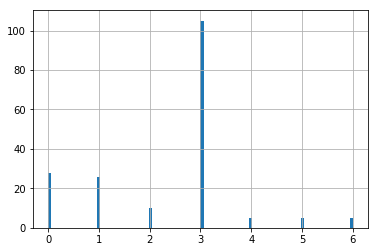

In [233]:
df['Всего нарушений'].hist(bins = 100)

todo:

статы по негативным тэгам
кластеризация комментов по группам? v2v? 

**text clustering**

**ngrams**

In [163]:
full_min_text = ''
for t in df[df.review_rating == 1].review_lemmatized.values:
    if pd.notnull(t):
        full_min_text += t

In [164]:
from nltk.util import ngrams
import collections

In [165]:
sixgrams = ngrams(full_min_text.split(), 2)

result = collections.Counter(sixgrams)

In [166]:
for item, count in sorted(result.items()):
    if count >= 2:
        text = "{} {}".format(" ".join(item), count)
        print(text)

4ий номер 2
en delta 2
estrellas os 2
ждать пока 2
номер гостиница 2
сей пора 2


In [154]:
full_min_text

'Магазинов нет. Одна ерунда. И много быдло хачейEn espa?ol m?s abajo.\r\nIn english below.\r\nУ ребят работает схема: бронь вроде как на отель 4 звезды Дельта, а когда въезжаешь, то выясняется что селят в Гамму (3 звезды). Даже не смотря на это, ванная комната хуже чем у многих 2* отелей и хостелов, скрипучая душевая кабина 90х90 для 4*-ого номера это нонсенс... Бронируйте в Веге или Альфе. Либо сразу в Гамме, ибо нет ни единого смысла переплачивать за Дельту, т.к. жить будете всё равно в Гамме. Фотографии ванны т.н. 4*-ого номера прилагаются.\r\nEspa?ol: Cuidado con este hotel, porque aunque reserv?is en Delta (4 estrellas), os mandar?n a Gamma (3 estrellas). Os contar?n de todo intentando que cre?is que esa habitaci?n en sector Gamma pertenece a Delta. Y aunque acab?is en Delta, les adjunto fotos del ba?o de nuestra habitaci?n doble de "4 estrellas"... con ducha medio reventada de 90x90... No existe ninguna necesidad de pagar de m?s por Delta, reserven directamente en Gamma. A?n as?,

1. Тэги негатива - классификация негативных отзывов. - ( + график распредления. 
2. Кластеризация отзывов - большие позитивные (конкструктив) , маленькие негативные и т.д.
3. 

# Old data

In [7]:
df = pd.read_csv('data/reviews.csv', sep = ';', encoding='cp1251')

In [8]:
df.head()

Unnamed: 0                     place_id  \
0           0  ChIJxUJiGhlNtUYRjyucIeHbeVI   
1           1  ChIJxUJiGhlNtUYRjyucIeHbeVI   
2           2  ChIJxUJiGhlNtUYRjyucIeHbeVI   
3           3  ChIJxUJiGhlNtUYRjyucIeHbeVI   
4           4  ChIJxUJiGhlNtUYRjyucIeHbeVI   

                                          place_name  place_rating  \
0  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   
1  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   
2  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   
3  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   
4  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   

            place_website                                               text  \
0  http://www.roddom4.ru/  Рожала первый раз, пришли ночью, когда отошли ...   
1  http://www.roddom4.ru/  Самый лучший роддом столицы!!! Самый лучший ко...   
2  http://www.roddom4.ru/  Роддом #4 порадовал своей приятной атмосферой,...   
3  http://www.roddom4.ru/  Хороший роддом,  рожала там лапочку дочку. Отд...   
4  http://www.roddom4.ru/  Рожала в 2016 , обезболивание делали ни какие ...   

   rating          time  
0     5.0  1.500051e+09  
1     5.0  1.504410e+09  
2     5.0  1.480424e+09  
3     5.0  1.476048e+09  
4     1.0  1.484580e+09

In [9]:
df.shape

(642, 8)

In [10]:
df['review_lemmatized'] = df.text.apply(lambda x: preprocess(x) if pd.notnull(x) else '')

**pos / neg words classifier**

In [24]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

In [25]:
def extract_features(word_list):
    return dict([(word, True) for word in word_list])

In [26]:
features_positive = [(extract_features(f.split()),'Positive') for f in df[df.rating >= 4].review_lemmatized.values]
features_negative = [(extract_features(f.split()),'Negative') for f in df[df.rating <= 2].review_lemmatized.values]

In [27]:
# Split the data into train and test (80/20)
threshold_factor = 0.8
threshold_positive = int(threshold_factor * len(features_positive))
threshold_negative = int(threshold_factor * len(features_negative))

In [28]:
features_train = features_positive[:threshold_positive]+features_negative[:threshold_negative]
features_test = features_positive[threshold_positive:]+features_negative[threshold_negative:]

print("Number of training datapoints: ", len(features_train))
print("Number of test datapoints: ", len(features_test))

Number of training datapoints:  474
Number of test datapoints:  120


In [29]:
classifier = NaiveBayesClassifier.train(features_train)
print("Accuracy of the classifier: ", nltk.classify.util.accuracy(classifier, features_test))

Accuracy of the classifier:  0.8


In [30]:
# [x for x in df.review_lemmatized.values if pd.notnull(x) and 'прийти' in x]

In [31]:
classifier.show_most_informative_features()

Most Informative Features
                  прийти = True           Negati : Positi =     21.8 : 1.0
                    итог = True           Negati : Positi =     19.9 : 1.0
               отправить = True           Negati : Positi =     13.7 : 1.0
                спросить = True           Negati : Positi =     12.1 : 1.0
                отличный = True           Positi : Negati =     10.6 : 1.0
                  оплата = True           Negati : Positi =     10.5 : 1.0
                 ужасный = True           Negati : Positi =     10.2 : 1.0
               потратить = True           Negati : Positi =      9.2 : 1.0
            регистратура = True           Negati : Positi =      8.9 : 1.0
                 платить = True           Negati : Positi =      8.9 : 1.0


In [32]:
print("Top ten most informative words: ")

for item in classifier.most_informative_features()[:10]:
    print(item[0])

Top ten most informative words: 
прийти
итог
отправить
спросить
отличный
оплата
ужасный
потратить
регистратура
платить


**vis**

In [12]:
df['text_len'] = df.text.apply(lambda x: len(x) if pd.notnull(x) else 0)
# df.time = pd.to_datetime(df.time, unit = 's')

In [13]:
df.head(3)

Unnamed: 0                     place_id  \
0           0  ChIJxUJiGhlNtUYRjyucIeHbeVI   
1           1  ChIJxUJiGhlNtUYRjyucIeHbeVI   
2           2  ChIJxUJiGhlNtUYRjyucIeHbeVI   

                                          place_name  place_rating  \
0  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   
1  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   
2  Родильный дом №4, филиал №1 ГКБ им. В.В. Виног...           4.2   

            place_website                                               text  \
0  http://www.roddom4.ru/  Рожала первый раз, пришли ночью, когда отошли ...   
1  http://www.roddom4.ru/  Самый лучший роддом столицы!!! Самый лучший ко...   
2  http://www.roddom4.ru/  Роддом #4 порадовал своей приятной атмосферой,...   

   rating          time                                  review_lemmatized  \
0     5.0  1.500051e+09  рожать один прислать ночью отойти водыбыстро п...   
1     5.0  1.504410e+09  самый хороший роддом столица самый хороший кол...   
2     5.0  1.480424e+09  роддом порадовать свой приятный атмосфера добр...   

   text_len  
0      1732  
1       133  
2       799

clustering

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [15]:
clust_df = df[['rating', 'time', 'text_len']].copy()

In [16]:
clust_df.loc[:, :] = StandardScaler().fit_transform(clust_df.values)

In [17]:
km = KMeans(n_clusters=3)

In [18]:
clust_df['cluster'] = km.fit_predict(clust_df)

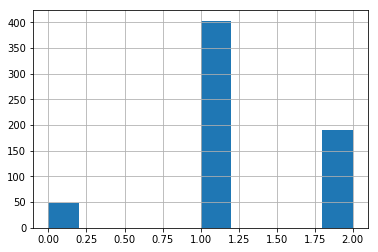

In [19]:
clust_df.cluster.hist()

In [20]:
import pandas as pd
import numpy as np
import os

import plotly.plotly as py
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
import plotly.graph_objs as go

from matplotlib import pyplot as plt
import seaborn as sns

init_notebook_mode(connected=True)

%matplotlib inline

In [21]:
clust_df.head(1)

rating      time  text_len  cluster
0  0.774494  0.490344  4.290444        2

In [23]:
data1 = []
for cluster, cluster_group in clust_df.groupby(['cluster']):
    x = cluster_group['rating']
    y = cluster_group['time']
    z = cluster_group['text_len']
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=6,
            line=dict(
                width=0.5
            ),
            opacity=0.8
        ),
#         name="Wine type %.d" % cluster
    )
    data1.append(trace)
    
layout = go.Layout(
#     width = 750,
    height = 800,
#     title='Кластеризация',
    scene = dict(
                    xaxis = dict(
                        title='rating'),
                    yaxis = dict(
                        title='time'),
                    zaxis = dict(
                        title='text_len'),),
    legend = dict(x = 0.8, y = 0.5),
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
    annotations=[
        dict(
            x=0.5,
            y=0.9,
#             text='Wine Classification',
            showarrow=False,
            font=dict(
                size=22,
            )
        ),
        dict(
            x=0.5,
            y=0.85,
#             text='Wine types by top-3 classifier features',
            showarrow=False,
#             font=dict(
#                 size=22,
#             )
        )
    ]
)

fig = go.Figure(data=data1, layout=layout)
iplot(fig, filename='basic-line')